<a href="https://colab.research.google.com/github/greisylargo/greisylargo.github.io/blob/master/Cifar10_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
# import libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from time import time as runtime
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
%matplotlib inline

## Load Data (Keras data)

In [173]:
from keras.datasets import cifar10
# load data
(train_X, train_Y), (test_X, test_Y) = cifar10.load_data()
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [174]:
# split training set into train and validation sets
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

train_X = train_X.reshape(-1,3072)
train_Y = list(train_Y.flatten())
test_X = test_X.reshape(-1,3072)
test_Y = list(test_Y.flatten())
val_X = val_X.reshape(-1,3072)
val_Y = list(val_Y.flatten())

In [175]:
train_X.shape, test_X.shape,val_X.shape

((40000, 3072), (10000, 3072), (10000, 3072))

### Visualize Original Image

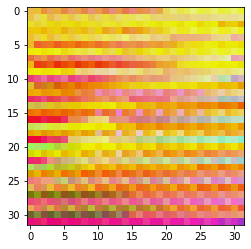

In [178]:
# visualize the original image
vis = test_X[1].reshape(3, 32, 32)
plt.imshow(np.transpose(vis, (1, 2, 0)), interpolation='none')

## PCA

In [179]:
t0 = runtime()
pca = PCA(n_components=100)
pca.fit(train_X)
print("Model built. Runtime: %.1f" % (runtime()-t0))

Model built. Runtime: 19.3


In [180]:
t0 = runtime()
train_pca = pca.transform(train_X)
val_pca = pca.transform(val_X)
test_pca = pca.transform(test_X)

print("Model built. Runtime: %.1f" % (runtime()-t0))

Model built. Runtime: 1.7


In [181]:
print('train_X shape:', train_pca.shape)
print('val_X shape:', val_pca.shape)
print('test_X shape:', test_pca.shape)

train_X shape: (40000, 100)
val_X shape: (10000, 100)
test_X shape: (10000, 100)


## Classifier

### Decision Tree

In [185]:
t0 = runtime()
model_dt = DecisionTreeClassifier()
model_dt = model_dt.fit(train_pca, train_Y)
print("Model built. Runtime: %.1fs." % (runtime()-t0))

Model built. Runtime: 10.6s.


In [184]:
# prediction
pred_dt = model_dt.predict(test_pca)
sum(pred_dt == test_Y)

2573

### Random Forest

In [186]:
t0 = runtime()
model_rf = RandomForestClassifier(n_estimators=50)
model_rf = model_rf.fit(train_pca, train_Y)
print("Model built. Runtime: %.1fs" % (runtime()-t0))

Model built. Runtime: 35.7s


In [187]:
# prediction
pred_rf = model_rf.predict(test_pca)
sum(pred_rf == test_Y)

4248

## Tuning Each Run

In [188]:
# hyper parameters
random.seed(1234)
d=100
n=500

In [189]:
# pca and classifier
print("Number of reduced dimensions:", d)
print("Number of trees:", n)
t0=runtime()
pca = PCA(n_components=d)
pca.fit(train_X)
train_pca = pca.transform(train_X)
test_pca = pca.transform(test_X)
t1=runtime()
print("PCA finished. Runtime: %.1fs." % (t1-t0))
model_rf = RandomForestClassifier(n_estimators=n)
model_rf = model_rf.fit(train_pca, train_Y)
t2=runtime()
print("Random Forest fitted. Runtime: %.1fs." % (t2-t1))
pred_rf = model_rf.predict(test_pca)
acc = sum(pred_rf == test_Y)/100
print("Accuracy: %.2f%%" % acc)
print("Total runtime: %.1fs." % (runtime()-t0))

Number of reduced dimensions: 100
Number of trees: 500
PCA finished. Runtime: 20.5s.
Random Forest fitted. Runtime: 357.2s.
Accuracy: 49.03%
Total runtime: 379.9s.


## Hyperparameters Tuning by Grid Search

In [190]:
# pipeline pca and classifier
model_rf = RandomForestClassifier()
pca_rf = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier())])
param_grid_rf = [{
                'pca__n_components': [100],
                'rf__n_estimators': [500]
                }]


#parameters_rf = {'pca__n_components':[10, 100, 500, 1000, 2000], 'rf__n_estimators':[10, 50, 70, 100, 130]}
grid_cv_rf = GridSearchCV(estimator=pca_rf, cv=5, param_grid=param_grid_rf)

In [191]:
t0 = runtime()
grid_cv_rf.fit(train_X, train_Y)
print("Model built. Runtime: %.1fs" % (runtime()-t0))

Model built. Runtime: 1843.1s


In [192]:
grid_cv_rf.cv_results_['mean_test_score']

array([0.48])

In [193]:
grid_cv_rf.cv_results_['params']

[{'pca__n_components': 100, 'rf__n_estimators': 500}]

In [194]:
pca_rf2 = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier())])
param_grid_rf2 = {
                'pca__n_components': [20],
                'rf__n_estimators': [120]
                }
grid_cv_rf2 = GridSearchCV(estimator=pca_rf2, cv=3, param_grid=param_grid_rf2)

In [195]:
t0 = runtime()
grid_cv_rf2.fit(train_X, train_Y)
print("Model built. Runtime: %.1fs" % (runtime()-t0))

Model built. Runtime: 131.8s


In [196]:
grid_cv_rf2.cv_results_['mean_test_score']

array([0.44])

In [197]:
grid_cv_rf2.cv_results_['params']

[{'pca__n_components': 20, 'rf__n_estimators': 120}]

## Evaluation

In [198]:
def plot_confusion_matrix(cm, classes, normalize, title):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    title_font = {'family': 'serif', 'color': 'black', 'weight': 'bold', 'size': 15}
    label_font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 10}
    plt.title(title, fontdict=title_font)
    plt.ylabel('True label',fontdict=label_font)
    plt.xlabel('Predicted label',fontdict=label_font)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()

In [212]:
# predict data use the model tuned
val_pca_evaluate = pca.transform(val_X)
#model_rf = model_rf.fit(train_pca, train_Y)
Y_pred = model_rf.predict(val_pca_evaluate)

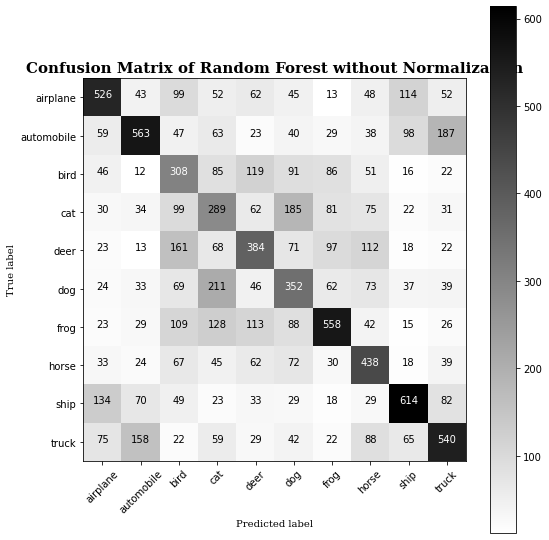

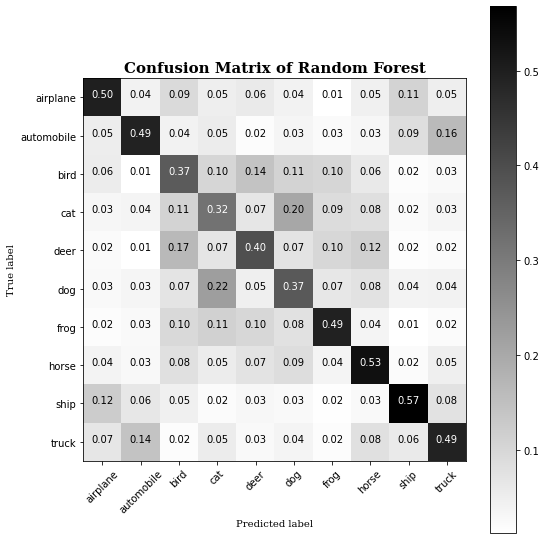

In [214]:
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_pred, val_Y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=False, 
                      title='Confusion Matrix of Random Forest without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=label_names, normalize=True, 
                      title='Confusion Matrix of Random Forest')

In [216]:
print(classification_report(val_Y, Y_pred, target_names=label_names))

              precision    recall  f1-score   support

    airplane       0.50      0.54      0.52       973
  automobile       0.49      0.58      0.53       979
        bird       0.37      0.30      0.33      1030
         cat       0.32      0.28      0.30      1023
        deer       0.40      0.41      0.40       933
         dog       0.37      0.35      0.36      1015
        frog       0.49      0.56      0.52       996
       horse       0.53      0.44      0.48       994
        ship       0.57      0.60      0.59      1017
       truck       0.49      0.52      0.50      1040

    accuracy                           0.46     10000
   macro avg       0.45      0.46      0.45     10000
weighted avg       0.45      0.46      0.45     10000

